In [1]:
from tqdm import tqdm_notebook
import datetime
import dpkt
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import open3d as op3

In [2]:
def test():
    temp = [1,2,3,4]
    i = 0
    while True:
        i+=1
        yield temp[i]

In [3]:
gen = test()

In [6]:
next(gen)

4

In [2]:
omega = np.array([[-25,1.4],[-1,-4.2],[-1.667,1.4],[-15.639,-1.4],
    [-11.31,1.4],[0,-1.4],[-0.667,4.2],[-8.843,-1.4],
    [-7.254,1.4],[0.333,-4.2],[-0.333,1.4],[-6.148,-1.4],
    [-5.333,4.2],[1.333,-1.4],[0.667,4.2],[-4,-1.4],
    [-4.667,1.4],[1.667,-4.2],[1,1.4],[-3.667,-4.2],
    [-3.333,4.2],[3.333,-1.4],[2.333,1.4],[-2.667,-1.4],
    [-3,1.4],[7,-1.4],[4.667,1.4],[-2.333,-4.2],
    [-2,4.2],[15,-1.4],[10.333,1.4],[-1.333,-1.4]
])

In [3]:


class LidarLoader():
    def __init__(self,file_path):
        self.Data_order = np.array([[-25,1.4],[-1,-4.2],[-1.667,1.4],[-15.639,-1.4],
    [-11.31,1.4],[0,-1.4],[-0.667,4.2],[-8.843,-1.4],
    [-7.254,1.4],[0.333,-4.2],[-0.333,1.4],[-6.148,-1.4],
    [-5.333,4.2],[1.333,-1.4],[0.667,4.2],[-4,-1.4],
    [-4.667,1.4],[1.667,-4.2],[1,1.4],[-3.667,-4.2],
    [-3.333,4.2],[3.333,-1.4],[2.333,1.4],[-2.667,-1.4],
    [-3,1.4],[7,-1.4],[4.667,1.4],[-2.333,-4.2],
    [-2,4.2],[15,-1.4],[10.333,1.4],[-1.333,-1.4]
])
        self.timing_offset = self.calc_timing_offsets()
        self.omega = self.Data_order[:,0]
        self.lidar_reader = 0
        self.file_path = file_path
        self.load_reader()

    def load_reader(self):
        try:
            fpcap = open(self.file_path, 'rb')
            self.lidar_reader = dpkt.pcap.Reader(fpcap)
        except Exception as ex:
            print(str(ex))

    def read_uint32(self,data, idx):
        return data[idx] + data[idx+1]*256 + data[idx+2]*256*256 + data[idx+3]*256*256*256
    def read_firing_data(self,data):
        block_id = data[0] + data[1]*256
        azimuth = (data[2] + data[3] * 256) / 100 # degree
        firings = data[4:].reshape(32, 3) 
        distances = firings[:, 0] + firings[:, 1] * 256 # mm 
        intensities = firings[:, 2] # 0-255
        return distances, intensities, azimuth #(1,0)
    
    def calc_timing_offsets(self):
        timing_offsets = np.zeros((32,12))  # Init matrix
        # constants
        full_firing_cycle = 55.296  # μs
        single_firing = 2.304  # μs
        # compute timing offsets
        for x in range(12):
            for y in range(32):
                dataBlockIndex = (x * 2) + int((y / 16))
                dataPointIndex = y % 16
                timing_offsets[y][x] = (full_firing_cycle * dataBlockIndex) +(single_firing * dataPointIndex)
        return np.array(timing_offsets).T

    def calc_precise_azimuth(self,azimuth):
        org_azi = azimuth.copy()

        precision_azimuth = []
        # iterate through each block
        for n in range(12): # n=0..11
            azimuth = org_azi.copy()
            try:
                # First, adjust for an Azimuth rollover from 359.99° to 0°
                if azimuth[n + 1] < azimuth[n]:
                    azimuth[n + 1] += 360

                # Determine the azimuth Gap between data blocks
                azimuth_gap = azimuth[n + 1] - azimuth[n]
            except:
                if azimuth[n] < azimuth[n-1]:
                    azimuth[n] += 360
                azimuth_gap = azimuth[n] - azimuth[n-1]

            factor = azimuth_gap / 32.
            k = np.arange(32)
            precise_azimuth = azimuth[n] + factor * k
            precision_azimuth.append(precise_azimuth)

        precision_azimuth = np.array(precision_azimuth)
        return precision_azimuth

    def calc_cart_coord(self,distances, azimuth):# distance: 12*32 azimuth: 12*32
        # convert deg to rad
        longitudes = self.omega * np.pi / 180.
        latitudes = azimuth * np.pi / 180.

        hypotenuses = distances * np.cos(longitudes)

        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = distances * np.sin(longitudes)
        return X, Y, Z

    def parse_one_packet(self,data):
        data = np.frombuffer(data, dtype=np.uint8).astype(np.uint32)
        blocks = data[0:1200].reshape(12, 100)
        Timestamp = self.read_uint32(data[1200:1204],0)
        distances = []#12*32
        intensities = []#12*32
        azimuth_per_block = [] #(12,0)
        # iteratie through each block
        for i, blk in enumerate(blocks):
            dists, intens, angles = self.read_firing_data(blk)
            distances.append(dists) #12*32
            intensities.append(intens) #12*32
            azimuth_per_block.append(angles)
        azimuth_per_block = np.array(azimuth_per_block) #12, 
            ## Note: all these arrray have th same size, number of firing in one packet
        azimuth_adjusted = self.calc_precise_azimuth(azimuth_per_block).reshape(12, 32) # 12*32
        azimuth_origin = np.tile(azimuth_per_block.reshape(-1,1),32)
        
        azimuth_adjusted += self.Data_order[:,1] # offset
        distances = np.array(distances)*4/1000 # 12*32
        intensities = np.array(intensities) # 12*32
        laser_id = np.tile(np.arange(32).reshape(-1,1),12).T
        
        # now calculate the cartesian coordinate of each point
        X, Y, Z = self.calc_cart_coord(distances, azimuth_adjusted)
        
        # calculating timestamp [microsec] of each firing
        timestamps = Timestamp + self.timing_offset

        X = X.flatten()
        Y = Y.flatten()
        Z = Z.flatten()
        intensities = intensities.flatten()
        azimuth_adjusted = azimuth_adjusted.flatten()
        timestamps = timestamps.flatten()
        distances = distances.flatten()
        azimuth_origin = azimuth_origin.flatten()
        laser_id = laser_id.flatten()
        # remeber the last azimuth for roll over checking
        return X, Y, Z, intensities, azimuth_adjusted, timestamps, distances, azimuth_origin, laser_id

    def frame_gen(self):
        while True:
            cur_culmulative_fires = 0
            frame = []
            flag = True
            for ts,buf in self.lidar_reader:
                eth = dpkt.ethernet.Ethernet(buf)
                data = eth.data.data.data
                packet_status = eth.data.data.sport
                if packet_status == 2368:
                    cur_culmulative_fires+=1
                    if len(data)<1206:
                        continue
                    X,Y,Z,I,A,T,D,A_O,L_id = self.parse_one_packet(data)
                    A[A>360] -= 360
                    frame.append(np.concatenate([T.reshape((-1,1)),
                                                    X.reshape((-1,1)),
                                                    Y.reshape((-1,1)),
                                                    Z.reshape((-1,1)),
                                                    D.reshape((-1,1)),
                                                    I.reshape((-1,1)),
                                                    ],axis = 1))
                    if cur_culmulative_fires==150:
                        cur_culmulative_fires = 0
                        temp = np.concatenate(frame)
                        temp = temp[(temp[:,4]!=0)&(temp[:,4]<60)] # filter out sky laser
                        frame = []
                        yield temp    
                else:
                    continue


In [39]:
os.chdir(r'/Users/czhui960/Documents/Lidar/to ZHIHUI/USA pkwy')
file_path  = os.listdir()[-2]
loader = LidarLoader(file_path).frame_gen()
frame = next(loader)
grid_height = (frame[:,3].max()-frame[:,3].min())
grid_width = 60*2
grid_length = 60*2
resolution = 0.2
bf_frames = 17000
bf_threshold = 0.15
X_coordinates = np.arange(-grid_width/2,grid_width/2,resolution)
Y_coordinates = np.arange(-grid_length/2,grid_length/2,resolution)
Z_coordinates = np.arange(frame[:,3].min(),frame[:,3].max(),resolution)
X, Y ,Z = np.meshgrid(X_coordinates, 
                      Y_coordinates,
                     Z_coordinates)
grid_3d_points = np.vstack((X,Y,Z)).reshape(3,-1).T
pcd_total_voxel = op3.geometry.PointCloud()
pcd_total_voxel.points = op3.utility.Vector3dVector(grid_3d_points)
voxel_grid = op3.geometry.VoxelGrid.create_from_point_cloud(pcd_total_voxel,voxel_size=resolution)
total_counts = np.zeros((len(X_coordinates),len(Y_coordinates),len(Z_coordinates)))
for frame in tqdm_notebook(range(bf_frames)):
    counts = np.zeros((len(X_coordinates),len(Y_coordinates),len(Z_coordinates)))
    frame = next(loader)
    frame_xyz = frame[:,[1,2,3]]
    for i in range(len(frame_xyz)):
        voxel_cors = voxel_grid.get_voxel(frame_xyz[i])
        try:
            if counts[voxel_cors[0],voxel_cors[1],voxel_cors[2]]==0:
                counts[voxel_cors[0],voxel_cors[1],voxel_cors[2]]+=1
        except:
            continue
    total_counts = total_counts +counts
total_counts = total_counts/bf_frames
Background_X,Background_Y,Background_Z = np.where(total_counts>bf_threshold)
Background_X = X_coordinates[Background_X]
Background_Y = Y_coordinates[Background_Y]
Background_Z = Z_coordinates[Background_Z]
Background_XYZ = np.concatenate([Background_X.reshape(-1,1),Background_Y.reshape(-1,1),Background_Z.reshape(-1,1)],axis = 1)
pcd_bck = op3.geometry.PointCloud()
pcd_bck.points = op3.utility.Vector3dVector(Background_XYZ)
voxel_grid_bck = op3.geometry.VoxelGrid.create_from_point_cloud(pcd_bck,voxel_size=resolution)

/Users/czhui960/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [41]:
Background_X,Background_Y,Background_Z = np.where(total_counts>0.07)
Background_X = X_coordinates[Background_X]
Background_Y = Y_coordinates[Background_Y]
Background_Z = Z_coordinates[Background_Z]
Background_XYZ = np.concatenate([Background_X.reshape(-1,1),Background_Y.reshape(-1,1),Background_Z.reshape(-1,1)],axis = 1)
pcd_bck = op3.geometry.PointCloud()
pcd_bck.points = op3.utility.Vector3dVector(Background_XYZ)
voxel_grid_bck = op3.geometry.VoxelGrid.create_from_point_cloud(pcd_bck,voxel_size=resolution)

In [42]:
op3.io.write_voxel_grid('./bck_voxel.ply',voxel_grid_bck)

True

## animation

In [136]:
Background_X,Background_Y,Background_Z = np.where(total_counts>0.005)
Background_X = X_coordinates[Background_X]
Background_Y = Y_coordinates[Background_Y]
Background_Z = Z_coordinates[Background_Z]
Background_XYZ = np.concatenate([Background_X.reshape(-1,1),Background_Y.reshape(-1,1),Background_Z.reshape(-1,1)],axis = 1)
pcd_bck = op3.geometry.PointCloud()
pcd_bck.points = op3.utility.Vector3dVector(Background_XYZ)
voxel_grid_bck = op3.geometry.VoxelGrid.create_from_point_cloud(pcd_bck,voxel_size=resolution)

In [126]:
os.chdir(r'/Users/czhui960/Documents/Lidar/to ZHIHUI/USA pkwy')
file_path  = os.listdir()[-2]
loader = LidarLoader(file_path).frame_gen()
# voxel_grid_bck = op3.io.read_voxel_grid('./Results/bck_voxel.ply')

In [128]:
detecting_range = 60
x_lim = [-detecting_range,detecting_range]
y_lim = [-detecting_range,detecting_range]

In [131]:
for i in tqdm_notebook(range(4600)):
    plt.figure(figsize=(20,int(20*((y_lim[1]-y_lim[0])/(x_lim[1]-x_lim[0])))))
    plt.ylim(y_lim[0],y_lim[1]) # figure height is 80
    plt.xlim(x_lim[0],x_lim[1]) # length is 150
    frame = next(loader)
    frame_xyz = frame[:,[1,2,3]]
    filtered_labels = ~np.array(voxel_grid_bck.check_if_included(op3.utility.Vector3dVector(frame_xyz)))
    points = frame_xyz[filtered_labels][:,[0,1]]
    plt.scatter(points[:,0],points[:,1],s = 3, marker = 'x')
    plt.savefig('./Results/Gifs/{}.png'.format(i))
    plt.close()

/Users/czhui960/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [43]:
os.chdir(r'/Users/czhui960/Documents/Lidar/to ZHIHUI/USA pkwy')
file_path  = os.listdir()[-2]
loader = LidarLoader(file_path).frame_gen()
# voxel_grid_bck = op3.io.read_voxel_grid('./Results/bck_voxel.ply')
for i in tqdm_notebook(range(644)):
    frame = next(loader)
#     frame_xyz = frame[:,[1,2,3]]

/Users/czhui960/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


## Background filtering 

In [65]:
Background_X,Background_Y,Background_Z = np.where(total_counts>0.02)
Background_X = X_coordinates[Background_X]
Background_Y = Y_coordinates[Background_Y]
Background_Z = Z_coordinates[Background_Z]
Background_XYZ = np.concatenate([Background_X.reshape(-1,1),Background_Y.reshape(-1,1),Background_Z.reshape(-1,1)],axis = 1)
pcd_bck = op3.geometry.PointCloud()
pcd_bck.points = op3.utility.Vector3dVector(Background_XYZ)
voxel_grid_bck = op3.geometry.VoxelGrid.create_from_point_cloud(pcd_bck,voxel_size=resolution)

## total grid and voxel_grid 

In [66]:
# frame = next(loader)
frame_xyz = frame[:,[1,2,3]]
filtered_labels = ~np.array(voxel_grid_bck.check_if_included(op3.utility.Vector3dVector(frame_xyz)))
pcd = op3.geometry.PointCloud()
pcd.points = op3.utility.Vector3dVector(frame_xyz[filtered_labels])
op3.visualization.draw_geometries([pcd_total_voxel,voxel_grid_bck])

## voxel grid and point clouds 

In [67]:
# frame = next(loader)
frame_xyz = frame[:,[1,2,3]]
filtered_labels = ~np.array(voxel_grid_bck.check_if_included(op3.utility.Vector3dVector(frame_xyz)))
pcd = op3.geometry.PointCloud()
pcd.points = op3.utility.Vector3dVector(frame_xyz[filtered_labels])
op3.visualization.draw_geometries([pcd,voxel_grid_bck])

In [133]:
import imageio

In [134]:
images = []
filenames = ['./Results/Gifs/{}.png'.format(i) for i in range(4600)]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./Results/{}.gif'.format('test'), images)
print('Gif successfully saved')

NameError: name 'file_name' is not defined

In [68]:
os.getcwd()

'/Users/czhui960/Documents/Lidar/to ZHIHUI/USA pkwy'

In [70]:
test_data = pd.read_csv(r'/Users/czhui960/Documents/2018-04-01.csv')

In [80]:
test_data.ROUTEID.unique()

array([       6,    18301,      124,      163,      101,      123,
            532,      111,        0,      522,       48,        5,
         160831,       59,       37,       27,      172,      527,
         160810,      113,      167,       66,       28,       98,
         999910,       87,   170601,     3801,       72,       17,
            150,   160811,       65,      153,       55,       20,
             91,   160805,   160830,      118,      106,        2,
             23,   210701,      302,      102,      336,   180003,
            317,   170001,      108,       42,       14,      155,
             86,       95,       79,      152,      170,       76,
             49,      602,       62, 31200023,      178,       22,
             33, 50100148,       97,   160638,      528,      327,
         999901,   190001,      308,   170007,      306,   180002,
            316,       68,   200007,      125,      171,      187,
          17101,      128,      129,       18,      197,      

In [81]:
groups = []
for g in test_data.groupby('ROUTEID'):
    groups.append(g[1])

In [89]:
import matplotlib.pyplot as plt

In [ ]:
test_data = test_data

In [103]:
locs = test_data.loc[:,['LONGITUDE','LATITUDE']].dropna()

In [104]:
locs = locs.loc[(locs.LONGITUDE!=0) & (locs.LATITUDE!=0)]

In [105]:
locs = np.array(locs)

In [106]:
locs = locs[locs[:,0]>118]

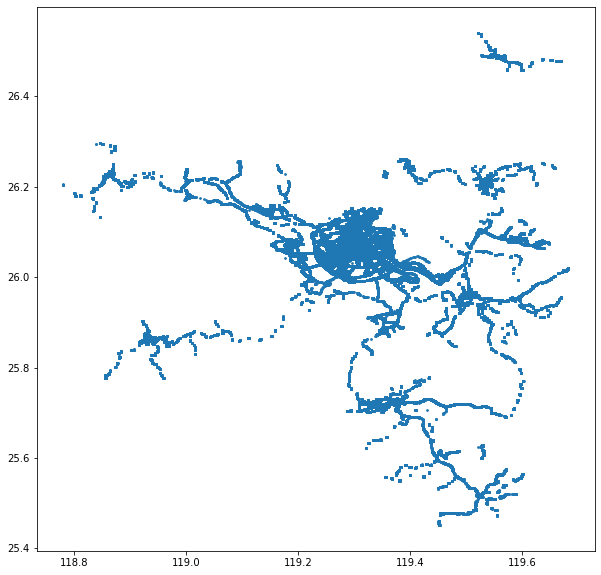

In [107]:
plt.figure(figsize=(10,10))
plt.scatter(np.array(locs)[:,0],np.array(locs)[:,1],s = 3)
plt.show()

In [109]:
486/3600

0.135

In [86]:
groups[1]

,BUSRDID,DATATYPE,ROUTEID,SUBROUTEID,PRODUCTID,STATIONSEQNUM,STATIONNUM,ISARRLFT,ACTDATETIME,RECDATETIME,...,RESERVECHAR14,RESERVECHAR15,RESERVECHAR16,PECCANCYSTARTTIME,PECCANCYENDTIME,PECCANCYMAXVALUE,PECCANCYAVGVALUE,BUSSELFID,FILEPATH,SENSORMILEAGE
397,777231089,4,1,1,810119,34,2071,1.0,2018-04-01 07:11:00,2018-04-01 07:10:28,...,NaN,27.156.116.130:49587,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN
632,777297604,55,1,1,810071,0,0,NaN,2018-04-01 07:23:51,2018-04-01 07:23:21,...,NaN,NaN,NaN,1970-01-01 08:00:00,1970-01-01 08:00:00,0.0,0.0,NaN,NaN,NaN
807,777231628,55,1,1,810071,0,0,NaN,2018-04-01 07:11:05,2018-04-01 07:10:34,...,NaN,NaN,NaN,1970-01-01 08:00:00,1970-01-01 08:00:00,0.0,0.0,NaN,NaN,NaN
970,777231090,12,1,0,810119,34,0,NaN,2018-04-01 07:11:00,2018-04-01 07:10:28,...,NaN,NaN,NaN,1970-01-01 08:00:00,1970-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN
1199,777298217,55,1,1,1080001,0,0,NaN,2018-04-01 07:24:00,2018-04-01 07:23:28,...,NaN,NaN,NaN,1970-01-01 08:00:00,1970-01-01 08:00:00,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4428517,781254065,12,1,0,810071,33,0,NaN,2018-04-01 22:21:26,2018-04-01 22:20:55,...,NaN,NaN,NaN,1970-01-01 08:00:00,1970-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN
4428644,781222106,4,1,1,810027,18,2662,2.0,2018-04-01 22:01:42,2018-04-01 22:01:12,...,NaN,27.156.116.130:49587,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN
4428645,781222107,12,1,0,810027,18,0,NaN,2018-04-01 22:01:42,2018-04-01 22:01:12,...,NaN,NaN,NaN,1970-01-01 08:00:00,1970-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN
4429032,781253195,4,1,1,810072,44,1056,1.0,2018-04-01 22:20:50,2018-04-01 22:20:18,...,NaN,27.156.116.130:49587,0.0,1970-01-01 08:00:00,1970-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN
